In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import numpy as np
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import feature_selection

In [19]:
# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Import data
data0 = pd.read_csv (r'./Data/df7.csv', encoding='utf-8')
data0 = data0.loc[pd.notnull(data0['rating']) & pd.notnull(data0['margin']),:] # filter out years that do not have rating
circuits = pd.read_csv('./Data/formula-1-race-data-19502017/circuits.csv', delimiter=',',encoding = "ISO-8859-1")

data0.describe()
data0.rating.quantile(.333)
data0.rating.quantile(.667)
data0.rating.quantile(.2)
data0.rating.quantile(.4)
data0.rating.quantile(.6)
data0.rating.quantile(.8)
bins = [0, 6.2, 7.50,10]
bins5 = [0,data0.rating.quantile(.2), data0.rating.quantile(.4),data0.rating.quantile(.6), 
        data0.rating.quantile(.8),10]
names = [1,2,3]
names5 = [1,2,3,4,5]
data0['ratingGroup'] = pd.cut(data0['rating'], bins, labels=names)
data0['ratingGroup5'] = pd.cut(data0['rating'], bins5, labels=names5)
#data.loc[pd.isnull(data['margin']),:]
data0['ratingRound'] = pd.Series.round(data0['rating'],decimals=0)

In [20]:
## create columns for categorical variables 
dummies = pd.get_dummies(data0.Weather, drop_first = True)
data1 = data0.join(dummies)

dummies2 = pd.get_dummies(data1.Clinched,drop_first = True)
data2 = data1.join(dummies2)

dummies3 = pd.get_dummies(data2.gp,drop_first = True)
data3 = data2.join(dummies3)

cir = circuits[['circuitId','type']].copy()
data4= pd.merge(data3, cir, on = 'circuitId', how = 'left')

dummies4 = pd.get_dummies(data4.type,drop_first = True)
data = data4.join(dummies4)

data['Rain'] = data['Varied'] + data['Wet'] 
#data['Rain'] 

In [21]:
## change categorical numbes to binary 
data.SCind = data.SCind.map(dict(Yes=1, No=0))
data.rename(columns={'Yes': 'Clinched_yes'}, inplace=True)
data['SCpercent'] = data['SCLaps'] /data['totalrace'] 
# fill the most frequent pit stops (3)
data.loc[pd.isnull(data['NPitStrategy']),'NPitStrategy'] = 3

In [22]:
#{data.columns.get_loc(c):c for idx, c in enumerate(data.columns)}

In [23]:

labels = data['rating']
location = ['Australian','Austrian','Azerbaijan','Bahrain','Belgian', 'Brazilian', 'British',
 'Canadian','Chinese', 'European', 'French','German','Hungarian','Indian','Italian', 'Japanese',
 'Korean', 'Malaysian', 'Mexican','Monaco','Russian','Singapore','Spanish','Turkish',
 'United States']

features = ['Rain','Overtakes_log','margin_log','SCpercent','Road','Street','spear',
            'log_hhi', 'Clinched_yes','round', 'NPitStrategy','totalrace','fastestTime',
            'change', 'fuel','drs']

numerical = ['totalrace','Overtakes_log','margin_log','round','change','log_hhi','SCpercent']

#'log_hhi', 'log_hhi_team','fuel','drs','fastestTime','NPitStrategy'

train1 = data.loc[:, features]

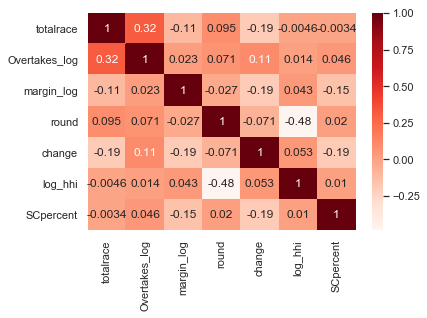

In [43]:
numfeature = data[numerical]
cor = numfeature.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)


In [25]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.10,random_state =2)

In [26]:
## Linear Regression 
reg = LinearRegression()
reg.fit(X_train,y_train)
print('Training score: {}'.format(reg.score(X_train, y_train)))
print('Test score: {}'.format(reg.score(X_test, y_test)))

y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)

print('RMSE: {}'.format(rmse))
print('R2: {}'.format(metrics.r2_score(y_test, y_pred)))

Training score: 0.5628976513239109
Test score: 0.6631226104745394
RMSE: 0.7619234813189509
R2: 0.6631226104745394


In [42]:
from sklearn.feature_selection import RFECV
selector = RFECV(estimator = LinearRegression(), cv=10)
selector.fit(X_train,y_train)
print(selector.n_features_)

15


In [28]:
# Recursive Feature Elimination 
rfe = RFE(reg, 12)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
np.array(train1.columns)[rfe.support_!= 1]

[ True  True  True  True  True  True  True  True  True False False False
 False  True  True  True]
[1 1 1 1 1 1 1 1 1 3 4 2 5 1 1 1]


array(['round', 'NPitStrategy', 'totalrace', 'fastestTime'], dtype=object)

In [29]:
# Total number of features 
len(np.array(train1.columns))
np.array(train1.columns)

array(['Rain', 'Overtakes_log', 'margin_log', 'SCpercent', 'Road',
       'Street', 'spear', 'log_hhi', 'Clinched_yes', 'round',
       'NPitStrategy', 'totalrace', 'fastestTime', 'change', 'fuel',
       'drs'], dtype=object)

Text(0, 0.5, 'Predicted Values')

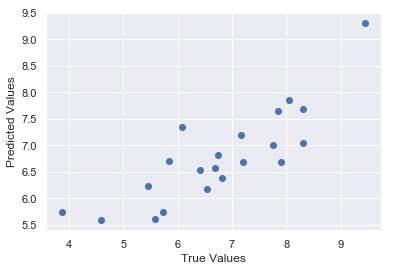

In [30]:
## The line / model
plt.scatter(x= y_test, y= y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

In [31]:
# Leave One Out Cross Validation 
labels = data['ratingGroup']
features = ['Rain','Overtakes_log','margin_log','SCpercent','Road','Street','spear',
            'log_hhi', 'Clinched_yes','round', 'NPitStrategy','totalrace','fastestTime',
            'change', 'fuel','drs']

#'log_hhi', 'log_hhi_team','fuel','drs','fastestTime','NPitStrategy'

train1 = data.loc[:, features]
X_train , X_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.10,random_state =2)

In [32]:
loo = LeaveOneOut()
ytests = []
ypreds = []
Xr = train1
yr = data['rating']
X_array = np.array(Xr)
y_array = np.array(yr)

for train_idx, test_idx in loo.split(Xr):
    X_train, X_test = X_array[train_idx], X_array[test_idx] #requires arrays
    y_train, y_test = y_array[train_idx], y_array[test_idx]
    
    model = LinearRegression()
    model.fit(X = X_train, y = y_train) 
    y_pred = model.predict(X_test)
        
    # there is only one y-test and y-pred per iteration over the loo.split, 
    # so to get a proper graph, we append them to respective lists.
        
    ytests += list(y_test)
    ypreds += list(y_pred)
        
rr = metrics.r2_score(ytests, ypreds)
ms_error = metrics.mean_squared_error(ytests, ypreds)
        
print("Leave One Out Cross Validation")
print("R^2: {:.5f}%, MSE: {:.5f}".format(rr*100, ms_error))

Leave One Out Cross Validation
R^2: 49.14673%, MSE: 0.86754


In [33]:
df = train1
y =  data['rating']

kf = KFold(n_splits = 5, shuffle = True)
reg = LinearRegression()

scores = []
for i in range(5):
    result = next(kf.split(df), None)
    x_train = df.iloc[result[0]]
    x_test = df.iloc[result[1]]
    y_train = y.iloc[result[0]]
    y_test = y.iloc[result[1]]
    model = reg.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    scores.append(metrics.r2_score(y_test, y_pred))
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

Scores from each Iteration:  [0.5391820739899125, 0.567532845057612, 0.5114908472771672, 0.5976785563065092, 0.5361266339034447]
Average K-Fold Score : 0.5504021913069291


In [39]:
# Decision Tree
labels = data['ratingGroup']
features = ['Rain','Overtakes_log','margin_log','SCpercent','Road','Street','spear',
            'log_hhi', 'Clinched_yes','round', 'NPitStrategy','totalrace','fastestTime',
            'change', 'fuel','drs']

#'log_hhi', 'log_hhi_team','fuel','drs','fastestTime','NPitStrategy'

train1 = data.loc[:, features]
X_train , X_test , y_train , y_test = train_test_split(train1 , labels , test_size = 0.10,random_state =2)
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
acc_decision_tree = decision_tree.score(X_test,y_test) 
acc_decision_tree


0.47619047619047616

In [ ]:
## Logistic Regression
model_1vR = LogisticRegression(multi_class='ovr',
    class_weight='balanced',solver='lbfgs')
model_1vR.fit(X_train, y_train)
#clf.score(X_train, y_train)
model_1vR.score(X_test,y_test)

In [ ]:
## Multinomial Logistic Regression

model_multi = LogisticRegression(multi_class='multinomial',
    solver='lbfgs', class_weight='balanced', max_iter = 5000)
model_multi.fit(X_train, y_train)
#model_multi.score(X_test, y_train)
model_multi.score(X_test,y_test)


In [ ]:
## Confusion Plots 
#y_pred=model_multi.predict(X_test)
#cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
#cnf_matrix

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Testing the model
predictions = rfc.predict(X_test)
rfc.score(X_test,y_test)